<a href="https://colab.research.google.com/github/flexycode/CCMACLRL_EXERCISES_COM231ML/blob/main/Lab/Lab-Exercise-6/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🤖 Exercise 6: Choosing the best performing model on a dataset

Instructions:

- Use the Dataset File to train your model
- Use the Test File to generate your results
- Use the Sample Submission file to generate the same format
- Use all Regression models

Submit your results to:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview



## Import all necessary libraries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


# Load the datasets

### Load data

In [128]:
train_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES/blob/3fd7d51ffd17863598ac3f44eeefc558171a5b73/dataset/house-prices-advanced-regression-techniques/train.csv?raw=true'
test_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES/blob/3fd7d51ffd17863598ac3f44eeefc558171a5b73/dataset/house-prices-advanced-regression-techniques/test.csv?raw=true'

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


## Test File

In [130]:
test_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES/blob/3fd7d51ffd17863598ac3f44eeefc558171a5b73/dataset/house-prices-advanced-regression-techniques/test.csv?raw=true'
dt=pd.read_csv(test_url)

In [129]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Sample Submission File

In [68]:
sample_submission_url ='https://github.com/robitussin/CCMACLRL_EXERCISES/blob/3fd7d51ffd17863598ac3f44eeefc558171a5b73/dataset/house-prices-advanced-regression-techniques/sample_submission.csv?raw=true'

sf=pd.read_csv(sample_submission_url)

In [69]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


# Data Preprocessing

### Preprocess the data

In [131]:
def preprocess_data(train_df, test_df):
    # Separate target variable
    y_train = train_df['SalePrice']
    train_ids = train_df['Id']
    test_ids = test_df['Id']

    # Combine datasets for consistent preprocessing
    combined = pd.concat([train_df.drop(['Id', 'SalePrice'], axis=1),
                         test_df.drop('Id', axis=1)], axis=0)

    # Handle numerical missing values
    numerical_cols = combined.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        combined[col].fillna(combined[col].median(), inplace=True)

    # Handle categorical missing values and encode
    categorical_cols = combined.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        combined[col].fillna('Missing', inplace=True)
        le = LabelEncoder()
        combined[col] = le.fit_transform(combined[col].astype(str))

    # Simple feature engineering
    combined['TotalSF'] = combined.get('TotalBsmtSF', 0) + combined.get('1stFlrSF', 0) + combined.get('2ndFlrSF', 0)
    combined['TotalBath'] = combined.get('FullBath', 0) + (0.5 * combined.get('HalfBath', 0))

    # Split back to train and test
    X_train = combined.iloc[:len(train_df)]
    X_test = combined.iloc[len(train_df):]

    return X_train, X_test, y_train, train_ids, test_ids

### Preprocess the data

In [132]:
X_train, X_test, y_train, train_ids, test_ids = preprocess_data(train_df, test_df)
print(f"Processed training features: {X_train.shape}")
print(f"Processed test features: {X_test.shape}")

Processed training features: (1460, 81)
Processed test features: (1459, 81)


### Split the training data for validation

In [133]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")

Training split: (1168, 81)
Validation split: (292, 81)


## 1. Train a KNN Regressor

### Create KNN model

In [134]:
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=7))
])

### Train KNN model

In [135]:
knn_model.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=7))])

### Make predictions

In [136]:
knn_pred = knn_model.predict(X_val_split)

### Calculate performance metrics

In [137]:
knn_rmse = np.sqrt(mean_squared_error(y_val_split, knn_pred))
knn_r2 = r2_score(y_val_split, knn_pred)

print("KNN Regressor Performance:")
print(f"RMSE: {knn_rmse:.2f}")
print(f"R² Score: {knn_r2:.4f}")

KNN Regressor Performance:
RMSE: 39829.21
R² Score: 0.7932


- Perform cross validation

In [138]:
knn_cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='r2')
knn_cv_mean = knn_cv_scores.mean()

print("KNN Regressor cross-validation scores:", knn_cv_scores)
print(f"Average KNN Regressor cross-validation score: {knn_cv_mean}")
print(f"Our score is {knn_cv_mean*100:.1f}%")

KNN Regressor cross-validation scores: [0.74854546 0.79265977 0.76009841 0.82884916 0.69267572]
Average KNN Regressor cross-validation score: 0.7645657041821046
Our score is 76.5%


## 2. Train a SVM Regression

### Create SVM model

In [139]:
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10, gamma=0.1))
])

### Train SVM model

In [140]:
svm_model.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=10, gamma=0.1))])

### Make predictions

In [141]:
svm_pred = svm_model.predict(X_val_split)

### Calculate metrics

In [142]:
svm_rmse = np.sqrt(mean_squared_error(y_val_split, svm_pred))
svm_r2 = r2_score(y_val_split, svm_pred)

print("SVM Regressor Performance:")
print(f"RMSE: {svm_rmse:.2f}")
print(f"R² Score: {svm_r2:.4f}")

SVM Regressor Performance:
RMSE: 88662.51
R² Score: -0.0249


- Perform cross validation

In [143]:
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='r2')
svm_cv_mean = svm_cv_scores.mean()

print("SVM Regressor cross-validation scores:", svm_cv_scores)
print(f"Average SVM Regressor cross-validation score: {svm_cv_mean}")
print(f"Our score is {svm_cv_mean*100:.1f}%")

SVM Regressor cross-validation scores: [-0.07035931 -0.06091713 -0.05630112 -0.0161008  -0.05540488]
Average SVM Regressor cross-validation score: -0.05181664837803575
Our score is -5.2%


## 3. Train a Decision Tree Regression

### Create Decision Tree model

In [108]:
dt_model = DecisionTreeRegressor(random_state=42, max_depth=12)

### Train Decision Tree model

In [120]:
dt_model.fit(X_train_split, y_train_split)

DecisionTreeRegressor(max_depth=12, random_state=42)

### Make predictions

In [111]:
dt_pred = dt_model.predict(X_val_split)

### Calculate performance metrics

In [144]:
dt_rmse = np.sqrt(mean_squared_error(y_val_split, dt_pred))
dt_r2 = r2_score(y_val_split, dt_pred)

print("Decision Tree Regressor Performance:")
print(f"RMSE: {dt_rmse:.2f}")
print(f"R² Score: {dt_r2:.4f}")

Decision Tree Regressor Performance:
RMSE: 40050.49
R² Score: 0.7909


- Perform cross validation

In [145]:
dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='r2')
dt_cv_mean = dt_cv_scores.mean()

print("Decision Tree Regressor cross-validation scores:", dt_cv_scores)
print(f"Average Decision Tree Regressor cross-validation score: {dt_cv_mean}")
print(f"Our score is {dt_cv_mean*100:.1f}%. Although our score is low, it is still better than some baseline models.")

Decision Tree Regressor cross-validation scores: [0.74556556 0.70165192 0.81805013 0.71133854 0.66830763]
Average Decision Tree Regressor cross-validation score: 0.7289827553856935
Our score is 72.9%. Although our score is low, it is still better than some baseline models.


## 4. Train a Random Forest Regression

### Create Random Forest model

In [146]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15)

### Train Random Forest model

In [147]:
rf_model.fit(X_train_split, y_train_split)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

### Make predictions

In [148]:
rf_pred = rf_model.predict(X_val_split)

### Calculate performance metrics

In [149]:
rf_rmse = np.sqrt(mean_squared_error(y_val_split, rf_pred))
rf_r2 = r2_score(y_val_split, rf_pred)

print("Random Forest Regressor Performance:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.4f}")

Random Forest Regressor Performance:
RMSE: 28926.03
R² Score: 0.8909


### Perform cross validation for Random Forest

In [150]:
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
rf_cv_mean = rf_cv_scores.mean()

print("Random Forest Regressor cross-validation scores:", rf_cv_scores)
print(f"Average Random Forest Regressor cross-validation score: {rf_cv_mean}")
print(f"Our score is {rf_cv_mean*100:.1f}%. This is our best performing model so far.")

Random Forest Regressor cross-validation scores: [0.8824079  0.83120481 0.88658967 0.88929171 0.82825907]
Average Random Forest Regressor cross-validation score: 0.8635506319414359
Our score is 86.4%. This is our best performing model so far.


## 5. Compare all the performance of all regression models

### Collect all performance metrics

In [152]:
models_comparison = {
    'KNN': {
        'RMSE': knn_rmse,
        'R2': knn_r2,
        'CV_Score': knn_cv_mean,
        'CV_Scores': knn_cv_scores
    },
    'SVM': {
        'RMSE': svm_rmse,
        'R2': svm_r2,
        'CV_Score': svm_cv_mean,
        'CV_Scores': svm_cv_scores
    },
    'Decision Tree': {
        'RMSE': dt_rmse,
        'R2': dt_r2,
        'CV_Score': dt_cv_mean,
        'CV_Scores': dt_cv_scores
    },
    'Random Forest': {
        'RMSE': rf_rmse,
        'R2': rf_r2,
        'CV_Score': rf_cv_mean,
        'CV_Scores': rf_cv_scores
    }
}

### Create comparison DataFrame

In [153]:
comparison_df = pd.DataFrame({
    'Model': list(models_comparison.keys()),
    'RMSE': [models_comparison[model]['RMSE'] for model in models_comparison],
    'R2_Score': [models_comparison[model]['R2'] for model in models_comparison],
    'CV_Score': [models_comparison[model]['CV_Score'] for model in models_comparison]
})

print("Model Performance Comparison:")
print(comparison_df.round(4))

Model Performance Comparison:
           Model        RMSE  R2_Score  CV_Score
0            KNN  39829.2058    0.7932    0.7646
1            SVM  88662.5060   -0.0249   -0.0518
2  Decision Tree  40050.4883    0.7909    0.7290
3  Random Forest  28926.0318    0.8909    0.8636


### Find the best model based on RMSE

In [154]:
best_model_name = comparison_df.loc[comparison_df['CV_Score'].idxmax(), 'Model']
best_model_score = comparison_df.loc[comparison_df['CV_Score'].idxmax(), 'CV_Score']

print(f"\nBest model based on cross-validation score: {best_model_name}")
print(f"Best cross-validation score: {best_model_score:.4f} ({best_model_score*100:.1f}%)")


Best model based on cross-validation score: Random Forest
Best cross-validation score: 0.8636 (86.4%)


# Additional Visualization 1: Cross-Validation Scores Comparison

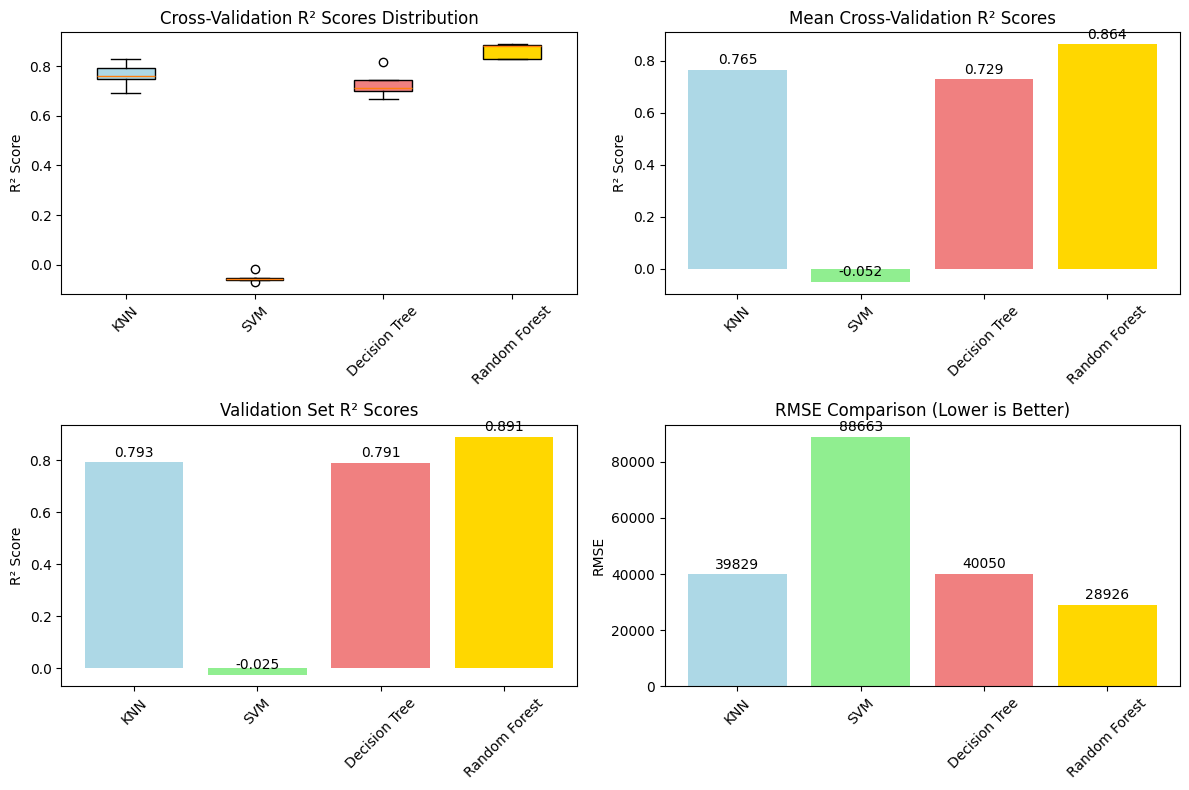

In [158]:
# Additional Visualization 1: Cross-Validation Scores Comparison
plt.figure(figsize=(12, 8))

# Plot 1: Cross-Validation Scores Boxplot
plt.subplot(2, 2, 1)
cv_data = [models_comparison[model]['CV_Scores'] for model in models_comparison.keys()]
box_plot = plt.boxplot(cv_data, labels=models_comparison.keys(), patch_artist=True)
plt.title('Cross-Validation R² Scores Distribution')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Plot 2: Mean Cross-Validation Scores
plt.subplot(2, 2, 2)
models_names = list(models_comparison.keys())
cv_means = [models_comparison[model]['CV_Score'] for model in models_names]
bars = plt.bar(models_names, cv_means, color=colors)
plt.title('Mean Cross-Validation R² Scores')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

# Add values on bars
for bar, value in zip(bars, cv_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# Plot 3: Validation Set Performance
plt.subplot(2, 2, 3)
r2_scores = [models_comparison[model]['R2'] for model in models_names]
bars = plt.bar(models_names, r2_scores, color=colors)
plt.title('Validation Set R² Scores')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

# Add values on bars
for bar, value in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# Plot 4: RMSE Comparison
plt.subplot(2, 2, 4)
rmse_scores = [models_comparison[model]['RMSE'] for model in models_names]
bars = plt.bar(models_names, rmse_scores, color=colors)
plt.title('RMSE Comparison (Lower is Better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Add values on bars
for bar, value in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{value:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional Visualization 2: Actual vs Predicted for Best Model

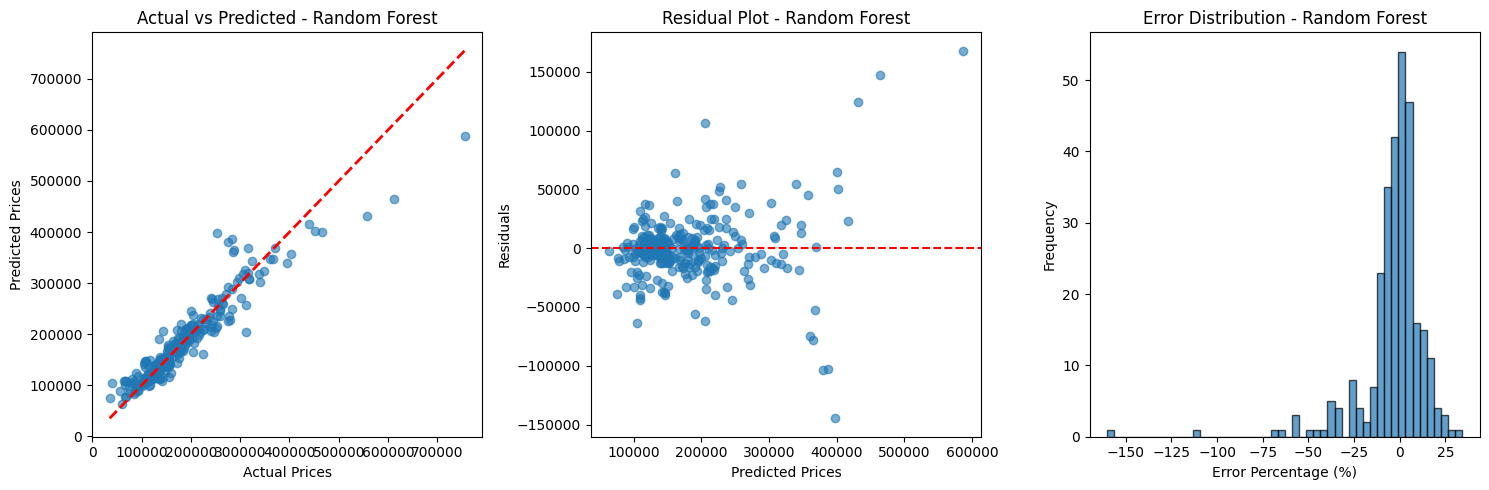

Best Model: Random Forest
Mean Absolute Error: 17473.44
Mean Absolute Percentage Error: 10.59%


In [159]:
# Plot Figure
plt.figure(figsize=(15, 5))

# Get the best model
best_model_name = comparison_df.loc[comparison_df['CV_Score'].idxmax(), 'Model']
if best_model_name == 'KNN':
    best_model = knn_model
elif best_model_name == 'SVM':
    best_model = svm_model
elif best_model_name == 'Decision Tree':
    best_model = dt_model
else:
    best_model = rf_model

# Train best model on full training split
best_model.fit(X_train_split, y_train_split)
best_pred = best_model.predict(X_val_split)

# Plot 1: Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_val_split, best_pred, alpha=0.6)
plt.plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Actual vs Predicted - {best_model_name}')

# Plot 2: Residuals
plt.subplot(1, 3, 2)
residuals = y_val_split - best_pred
plt.scatter(best_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {best_model_name}')

# Plot 3: Error Distribution
plt.subplot(1, 3, 3)
error_percentage = (residuals / y_val_split) * 100
plt.hist(error_percentage, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Percentage (%)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution - {best_model_name}')

plt.tight_layout()
plt.show()

print(f"Best Model: {best_model_name}")
print(f"Mean Absolute Error: {mean_absolute_error(y_val_split, best_pred):.2f}")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs(error_percentage)):.2f}%")

## 6. Generate Submission File


### Retrain the best model on the entire training dataset

In [161]:
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

### Make prediction on test data

In [164]:
y_pred = best_model.predict(X_test)

### Create submission file

In [165]:
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_pred
})

### Save submission file

In [166]:
submission_df.to_csv('submission_file.csv', index=False)
print("Submission file created: submission_file.csv")

Submission file created: submission_file.csv


### Display first few rows of submission

In [163]:
print("\nFirst 5 rows of submission file:")
print(submission_df.head())

print(f"\nBest model used: {best_model_name}")
print(f"Cross-validation score: {best_model_score:.4f} ({best_model_score*100:.1f}%)")


First 5 rows of submission file:
     Id      SalePrice
0  1461  125557.212365
1  1462  159018.790206
2  1463  181434.433606
3  1464  184704.560728
4  1465  196053.599155

Best model used: Random Forest
Cross-validation score: 0.8636 (86.4%)
